# Covid-19 Analysis

Looking at the Covid-19 data obtained from 'Our World in Data'.

**Index:**

- Extracting Data
    - Python imports
    - Fetch COVID-19 data from Our World in Data
    - Fetch Canadian specific data from [health-infobase.canada.ca](health-infobase.canada.ca)
- Filtering and Cleaning
    - Extract world record
    - Filtering for the latest data
    - Preparing population data
        -  Missing population data
    - Appending inferred information
    - Preparing Canadian specific data
- Analysis
    - World record
        - Plots
        - Table
    - Top 5: total cases per capita and deaths per total
        - Plots
        - Tables
    - Comparison between select countries
        - Plots
        - Tables
    - Highest number of total cases and deaths
        - Plots
        - Tables
    - Canadian provinces and territories
        - Canadian provinces and territories
        - Cases and Deaths
            - Plots
            - Tables
                - Total
                - Sorted by confirmed cases
        - Per Capita
            - Plots
            - Tables
                - Sorted by confirmed cases per capita
                - Population
- Resources

## Extracting coronavirus and country data

### Python Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import requests

from datetime import datetime

### Fetch COVID-19 data from Our World in Data

In [2]:
r = requests.get('https://covid.ourworldindata.org/data/ecdc/full_data.csv')

In [3]:
with open('full_data.csv', 'wb') as fd:
    for chunk in r.iter_content(chunk_size = 128):
        fd.write(chunk)

### Get Canadian specific data from health-infobase.canada.ca

In [4]:
r = requests.get('https://health-infobase.canada.ca/src/data/covidLive/covid19.csv')

In [5]:
with open('summary_current.csv', 'wb') as fd:
    for chunk in r.iter_content(chunk_size = 128):
        fd.write(chunk)

### Load data 

In [6]:
rdata = pd.read_csv('full_data.csv')
rpopulation_data = pd.read_csv('population_data.csv') 
canadian_data = pd.read_csv('summary_current.csv')
deaths_from_infections = pd.read_csv('deaths-from-infections-of-currently-noneradicable-diseases.csv')

In [7]:
canadian_population_dict = {'Population':[14711827, 8537674, 5110917, 4413146, 1377517, 1181666, 977457, 779993, 521365, 158158, 44904, 39097, 41078], 
                            'Location':['Ontario', 'Quebec', 'British Columbia', 'Alberta','Manitoba','Saskatchewan',
                                        'Nova Scotia', 'New Brunswick', 'Newfoundland and Labrador','Prince Edward Island', 'Northwest Territories','Nunavut','Yukon']}

canadian_population = pd.DataFrame.from_dict(canadian_population_dict)

## Filtering and cleaning data 

In [8]:
print("Data Types", rdata.dtypes)
print("Columns with NaN", rdata.columns[rdata.isna().any()])

Data Types date                object
location            object
new_cases          float64
new_deaths         float64
total_cases        float64
total_deaths       float64
weekly_cases       float64
weekly_deaths      float64
biweekly_cases     float64
biweekly_deaths    float64
dtype: object
Columns with NaN Index(['new_cases', 'new_deaths', 'total_cases', 'total_deaths',
       'weekly_cases', 'weekly_deaths', 'biweekly_cases', 'biweekly_deaths'],
      dtype='object')


In [9]:
pd.set_option("display.max_colwidth", -1)

/Users/ambreenhaleem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [10]:
rdata = rdata.fillna(value = 0)
pdata = rdata.astype({'new_cases':'int64', 
                     'new_deaths':'int64', 
                     'total_deaths':'int64'})
pdata.dtypes

date               object 
location           object 
new_cases          int64  
new_deaths         int64  
total_cases        float64
total_deaths       int64  
weekly_cases       float64
weekly_deaths      float64
biweekly_cases     float64
biweekly_deaths    float64
dtype: object

In [11]:
rdata['date_fm'] = pd.to_datetime(rdata['date'], infer_datetime_format='%Y-%m-%d')

In [12]:
latest = pdata['date'].max()
latest

'2020-11-09'

In [13]:
canadian_data['date'] = pd.to_datetime(canadian_data['date'], infer_datetime_format='%d-%m-%Y')

In [14]:
latest_canadian = canadian_data['date'].max()

In [15]:
latest_year = deaths_from_infections['Year'].max()
latest_year

2017

In [16]:
deaths_from_infections.drop('Code', axis = 1, inplace = True)

In [17]:
deaths_from_infections = deaths_from_infections[deaths_from_infections['Year'] == latest_year]

In [18]:
deaths_from_infections.rename(inplace = True, columns = 
                              {'Entity':'Location', 
                               'Malaria (deaths)': 'Malaria',
                               'Tuberculosis (deaths)':'Tuberculosis',
                               'HIV/AIDS (deaths)':'HIV/AIDS',
                               'Rabies (deaths)':'Rabies'})

In [19]:
deaths_from_infections.set_index('Location', inplace = True)

In [20]:
earliest = '2020-03-01'

### Extract world record

In [21]:
world_record = rdata[rdata['location'] == 'World']

In [22]:
world_record = world_record.drop(columns = ['date'])
world_record = world_record.set_index('date_fm')

In [23]:
diff = datetime.today() - datetime.fromisoformat(rdata['date'].min())

In [24]:
world_deaths_from_infections = deaths_from_infections[deaths_from_infections.index == 'World'].copy()
world_deaths_from_infections.drop(inplace = True, columns = ['Year'])

In [25]:
scale = 365
world_deaths_from_infections_scaled = world_deaths_from_infections.copy()
world_deaths_from_infections_scaled['Malaria'] = (world_deaths_from_infections['Malaria'].div(scale))
world_deaths_from_infections_scaled['Tuberculosis'] = (world_deaths_from_infections['Tuberculosis'].div(scale))
world_deaths_from_infections_scaled['Rabies'] = (world_deaths_from_infections['Rabies'].div(scale))
world_deaths_from_infections_scaled['HIV/AIDS'] = (world_deaths_from_infections['HIV/AIDS'].div(scale))

In [26]:
covid_19 = world_record['total_deaths'][world_record.index == latest][0]/diff.days
world_deaths_from_infections_scaled = world_deaths_from_infections_scaled.assign(COVID_19 = covid_19)

### Filtering for the latest data

In [27]:
data = pdata[pdata['date'] == latest]
data = data.drop('date', axis = 1)
data = data.set_index('location')

In [28]:
data = data[data.index != 'World']

In [29]:
max_total_cases = data['total_cases'].max()

In [30]:
canadian_data = canadian_data[canadian_data['date'] == latest_canadian]
canadian_data = canadian_data.drop(columns = ['pruid', 'date','prnameFR'])

### Preparing population data

In [31]:
population = rpopulation_data.filter(['Country Name', '2018'])

In [32]:
population = population.rename(columns = {'Country Name':'location'})
population = population.set_index('location')

#### Missing population data

In [33]:
data[data.index.isin(population.index) == False]

,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths
location,,,,,,,,
Anguilla,0,0,3.0,0,0.0,0.0,0.0,0.0
Bonaire Sint Eustatius and Saba,0,0,154.0,3,1.0,0.0,4.0,0.0
Falkland Islands,0,0,13.0,0,0.0,0.0,0.0,0.0
Guernsey,0,0,279.0,13,9.0,0.0,14.0,0.0
Jersey,0,0,643.0,32,69.0,0.0,113.0,0.0
Montserrat,0,0,13.0,1,0.0,0.0,0.0,0.0
Palestine,549,3,70161.0,587,4359.0,26.0,8115.0,69.0
Saint Kitts and Nevis,0,0,19.0,0,0.0,0.0,0.0,0.0
Taiwan,1,0,578.0,7,15.0,0.0,28.0,0.0


### Appending inferred information 

In [34]:
data['total_cases_per_capita'] = data['total_cases'].div(data.index.map(population['2018'])).mul(100000)
data['total_deaths_per_capita'] = data['total_deaths'].div(data.index.map(population['2018'])).mul(100000)
data['deaths_per_total'] = data['total_deaths'].div(data['total_cases'])
data['deaths_per_total'] = data['deaths_per_total'].round(decimals = 4)
data.head()

,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,,,,,
Afghanistan,80,3,42239.0,1565,606.0,24.0,1406.0,51.0,113.630048,4.210114,0.0371
Albania,501,2,24206.0,559,3004.0,41.0,5049.0,82.0,844.480975,19.501977,0.0231
Algeria,670,12,62051.0,2048,3779.0,75.0,5908.0,134.0,146.941294,4.849813,0.0330
Andorra,64,0,5383.0,75,558.0,0.0,1345.0,6.0,6990.364387,97.395008,0.0139
Angola,112,3,12335.0,303,1530.0,19.0,3309.0,36.0,40.036012,0.983455,0.0246


### Preparing Canadian specific data

In [35]:
canadian_data = canadian_data.rename(columns = {'numconf': 'Confirmed Cases', 
                                                'numprob':'Probable Cases',
                                                'numtotal':'Total',
                                                'numtoday':'Today',
                                                'numdeaths': 'Deaths',
                                                'prname':'Location'})

In [36]:
canadian_data.set_index('Location', inplace = True)
canadian_population.set_index('Location', inplace = True)

In [37]:
canadian_data_total = canadian_data[canadian_data.index == 'Canada']

In [38]:
canadian_data = canadian_data[canadian_data.index.isin(canadian_population.index) == True]
canadian_population = canadian_population[canadian_population.index.isin(canadian_data.index) == True]

In [39]:
canadian_data['Deaths per Confirmed Cases'] = (canadian_data['Deaths'].div(canadian_data['Confirmed Cases']))

In [40]:
canadian_data = canadian_data.assign(Confirmed_Cases_Per_Capita = canadian_data['Confirmed Cases'].div(canadian_population['Population']))
canadian_data = canadian_data.assign(Deaths_Per_Capita = canadian_data['Deaths'].div(canadian_population['Population']))

In [41]:
canadian_data.rename(columns = {'Confirmed_Cases_Per_Capita':'Confirmed Cases Per Capita', 
                                'Deaths_Per_Capita':'Deaths Per Capita'}, inplace = True)

## Analysis

### World record

#### Plots

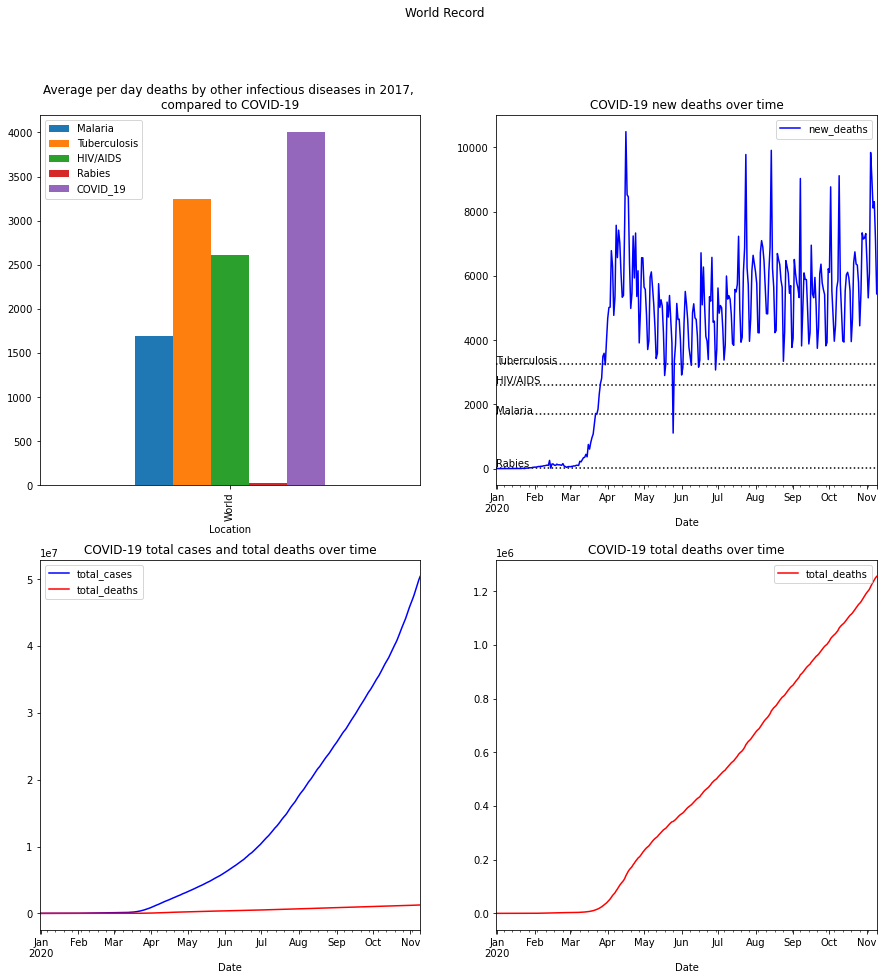

In [42]:
fig, ((ax3, ax4), (ax1, ax2)) = plt.subplots(2, 2, figsize = (15,15))
fig.suptitle('World Record')

world_record.index.name = 'Date'

# set titles

ax1.set_title('COVID-19 total cases and total deaths over time')
ax2.set_title('COVID-19 total deaths over time')

diffy = 26
ax3_title = 'Average per day deaths by other infectious diseases in ' + str(latest_year) +', \ncompared to COVID-19'
ax3.set_title(ax3_title)

ax4.set_title('COVID-19 new deaths over time')

world_record.plot(kind='line', y= ['total_cases', 'total_deaths'], color = ['blue', 'red'], ax = ax1)
world_record.plot(kind='line', y= 'total_deaths', color = 'red', ax = ax2)
world_deaths_from_infections_scaled.plot(kind = 'bar', ax = ax3)
world_record.plot(kind='line', y= 'new_deaths', color = 'blue', ax = ax4)

ax4.hlines(world_deaths_from_infections_scaled['Malaria'], world_record.index.min(), world_record.index.max(), linestyles = 'dotted')
ax4.text(world_record.index.min(), world_deaths_from_infections_scaled['Malaria']+diffy, 'Malaria')

ax4.hlines(world_deaths_from_infections_scaled['Rabies'], world_record.index.min(), world_record.index.max(), linestyles = 'dotted')
ax4.text(world_record.index.min(), world_deaths_from_infections_scaled['Rabies']+diffy, 'Rabies')

ax4.hlines(world_deaths_from_infections_scaled['Tuberculosis'], world_record.index.min(), world_record.index.max(), linestyles = 'dotted')
ax4.text(world_record.index.min(), world_deaths_from_infections_scaled['Tuberculosis']+diffy, 'Tuberculosis')

ax4.hlines(world_deaths_from_infections_scaled['HIV/AIDS'], world_record.index.min(), world_record.index.max(), linestyles = 'dotted')
ax4.text(world_record.index.min(), world_deaths_from_infections_scaled['HIV/AIDS']+diffy, 'HIV/AIDS')

plt.savefig('world.png', bbox_inches = 'tight')

#### Table

In [43]:
world_record[world_record.index == latest]

,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths
Date,,,,,,,,,
2020-11-09,World,462259.0,5440.0,50414235.0,1255831.0,3742729.0,53973.0,7186681.0,100161.0


In [44]:
world_deaths_from_infections

,Malaria,Tuberculosis,HIV/AIDS,Rabies
Location,,,,
World,619826.63466,1.183672e+06,954491.747216,11659.073233


In [45]:
world_deaths_from_infections_scaled

,Malaria,Tuberculosis,HIV/AIDS,Rabies,COVID_19
Location,,,,,
World,1698.155163,3242.937234,2615.045883,31.942666,3999.461783


### Top 5: total cases per capita and deaths per total

In [46]:
highest_total_cases_pc = data.nlargest(5, 'total_cases_per_capita')

In [47]:
highest_total_cases_pc = highest_total_cases_pc.merge(population, on = 'location')

In [48]:
deaths_per_cases = data[data['total_cases'] > 50].nlargest(5, 'deaths_per_total')
deaths_per_cases = deaths_per_cases.merge(population, on = 'location')

In [49]:
total_cases_for_table = highest_total_cases_pc.drop(columns = ['total_deaths_per_capita', 'deaths_per_total', 'new_deaths', 'total_deaths'])
total_cases_for_table = total_cases_for_table.reset_index()
total_cases_for_table = total_cases_for_table.rename(columns = {'2018':'population'})

In [50]:
deathsratio_for_table = deaths_per_cases.drop(columns = ['new_cases', 'new_deaths', 'total_cases_per_capita', 'total_deaths_per_capita'])
deathsratio_for_table = deathsratio_for_table.reset_index()
deathsratio_for_table = deathsratio_for_table.rename(columns = {'2018':'population'})

#### Plots

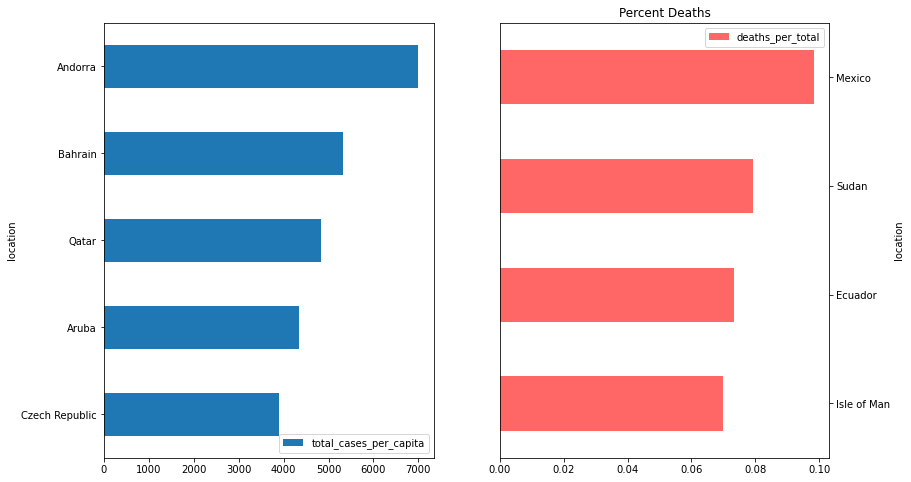

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8))
highest_total_cases_pc.sort_values(by = 'total_cases_per_capita', ascending = True).plot(kind='barh',y = 'total_cases_per_capita', ax = ax1,
                            ylim = (0, data['total_cases_per_capita'].max()+ 0.0005))

ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.set_title('Percent Deaths')
deaths_per_cases.sort_values(by = 'deaths_per_total', ascending = True).plot.barh(y = 'deaths_per_total', 
                                                      color ='red', ax = ax2,
                                                      alpha = 0.6)
plt.savefig('total_cases_per_capita_and_deaths_per_total.png', bbox_inches = 'tight')

#### Tables

##### Highest total cases per capita

In [52]:
total_cases_for_table

,location,new_cases,total_cases,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths,total_cases_per_capita,population
0,Andorra,64,5383.0,558.0,0.0,1345.0,6.0,6990.364387,77006.0
1,Bahrain,192,83456.0,1533.0,8.0,3201.0,17.0,5317.568889,1569439.0
2,Qatar,190,134203.0,1483.0,0.0,3033.0,2.0,4824.535703,2781677.0
3,Aruba,11,4600.0,81.0,2.0,180.0,4.0,4345.977609,105845.0
4,Czech Republic,3608,414828.0,73184.0,1429.0,156731.0,2657.0,3904.008161,10625695.0


##### Highest deaths to total cases

In [53]:
deathsratio_for_table

,location,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths,deaths_per_total,population
0,Mexico,967825.0,95027,38433.0,3132.0,76665.0,6103.0,0.0982,126190788.0
1,Sudan,14090.0,1115,271.0,278.0,348.0,278.0,0.0791,41801533.0
2,Ecuador,174907.0,12830,5713.0,146.0,13272.0,277.0,0.0734,17084357.0
3,Isle of Man,357.0,25,4.0,1.0,9.0,1.0,0.0700,84077.0


### Comparison between select countries

In [54]:
filter_countries = ['Canada','United States', 'Pakistan', 'China', 'Italy']

In [55]:
country_subset = rdata[rdata['location'].isin(filter_countries) & rdata['date_fm'].between(earliest, latest)]
country_subset = country_subset.drop(columns = ['date'])
country_subset = country_subset.set_index('date_fm')
country_subset.index.name = 'Date'

In [56]:
percapita = pd.DataFrame(country_subset['location'])
percapita['new_cases_per_capita'] =  country_subset['new_cases'].div(country_subset['location'].map(population['2018'])).mul(100000)

In [57]:
percapita_total = pd.DataFrame(country_subset['location'])
percapita_total['total_cases_per_capita'] =  country_subset['total_cases'].div(country_subset['location'].map(population['2018'])).mul(100000)

In [58]:
percapita_deaths = pd.DataFrame(country_subset['location'])
percapita_deaths['new_deaths_per_capita'] =  country_subset['new_deaths'].div(country_subset['location'].map(population['2018'])).mul(100000)

#### Plots

##### By new cases

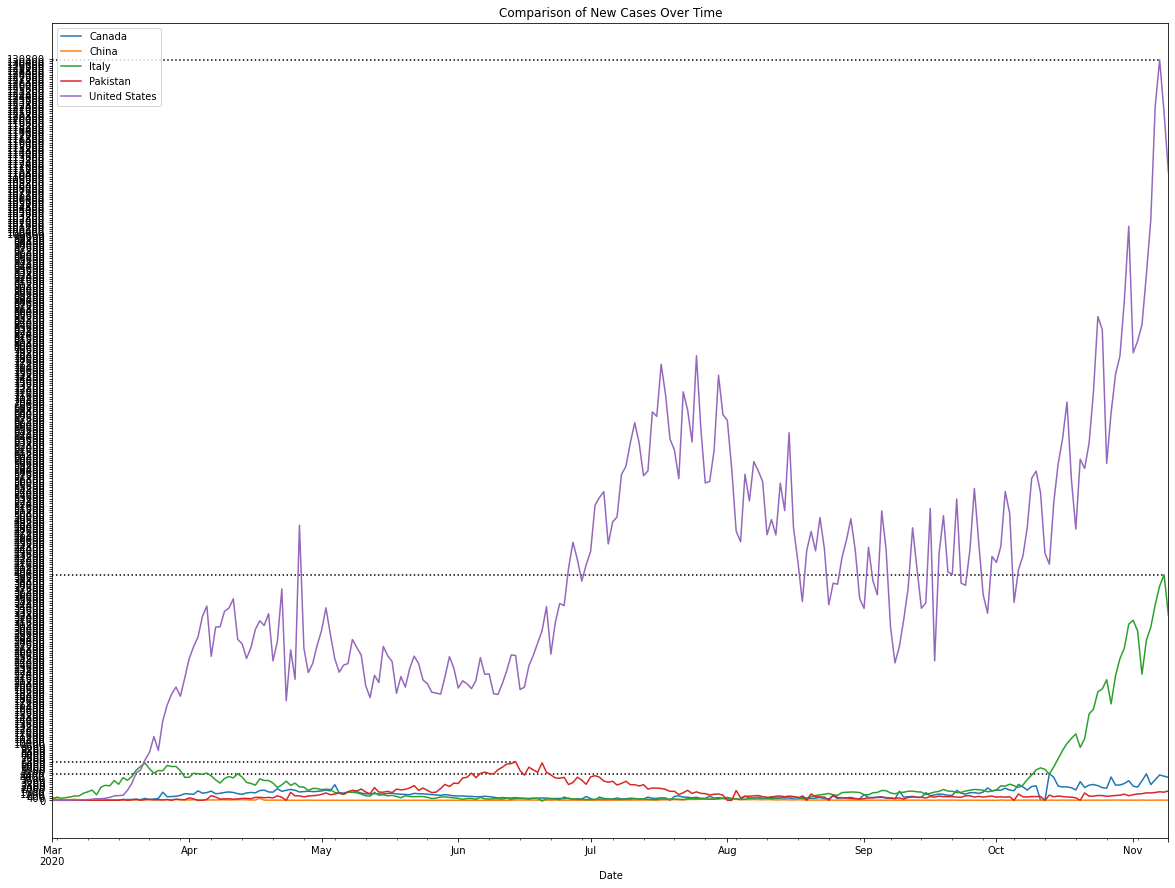

In [59]:
inc = 400

_, ax = plt.subplots(figsize = (20, 15))
ax.set_title('Comparison of New Cases Over Time')
ax.set_yticks(np.arange(0, country_subset['new_cases'].max()+inc, inc))

for name, group in country_subset.groupby('location'):
    group.plot(kind ='line', y = 'new_cases', ax = ax, label = name)
    
    max_record = group.loc[group['new_cases'].idxmax()]
    max_date = pd.to_datetime(max_record.name)
    max_new_cases = max_record['new_cases']
    plt.hlines(max_new_cases, earliest, max_date, linestyles = 'dotted')

plt.savefig('select_countries_new_cases.png', bbox_inches = 'tight')

##### New cases per capita

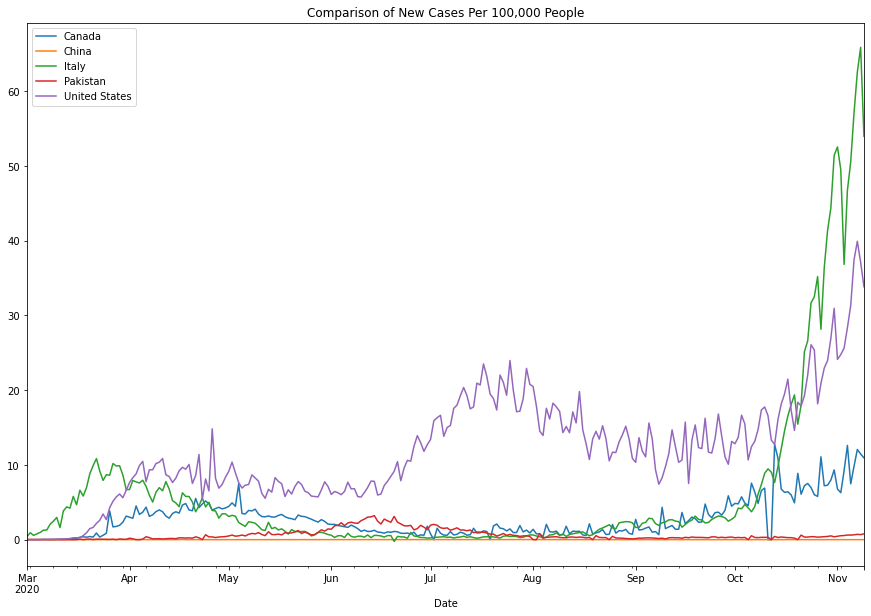

In [60]:
_, ax = plt.subplots(figsize = (15, 10))

ax.set_title('Comparison of New Cases Per 100,000 People')

for name, group in percapita.groupby('location'):
    group.plot(kind ='line', y = 'new_cases_per_capita', ax = ax, label = name)

plt.savefig('select_countries_new_cases_per_capita.png', bbox_inches = 'tight')

##### Total cases per capita

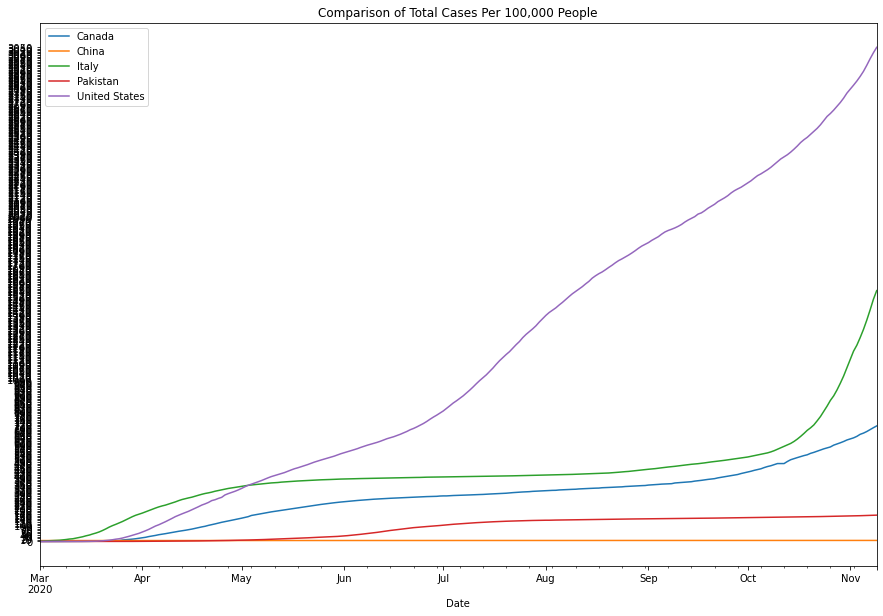

In [61]:
inc = 10

_, ax = plt.subplots(figsize = (15, 10))

ax.set_title('Comparison of Total Cases Per 100,000 People')
ax.set_yticks(np.arange(0, percapita_total['total_cases_per_capita'].max()+inc, inc))

for name, group in percapita_total.groupby('location'):
    group.plot(kind ='line', y = 'total_cases_per_capita', ax = ax, label = name)

plt.savefig('select_countries_total_cases_per_capita.png', bbox_inches = 'tight')

In [62]:
country_subset_latest = country_subset[country_subset.index == latest]
country_subset_latest

,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths
Date,,,,,,,,,
2020-11-09,Canada,4058.0,32.0,264113.0,10522.0,27272.0,343.0,48009.0,576.0
2020-11-09,China,32.0,0.0,91560.0,4739.0,213.0,0.0,409.0,0.0
2020-11-09,Italy,32614.0,331.0,935104.0,41394.0,225769.0,2568.0,409322.0,4056.0
2020-11-09,Pakistan,1650.0,9.0,344839.0,6977.0,9746.0,142.0,16237.0,238.0
2020-11-09,United States,110693.0,459.0,9971651.0,237572.0,764289.0,6576.0,1335486.0,12342.0


##### New deaths per capita

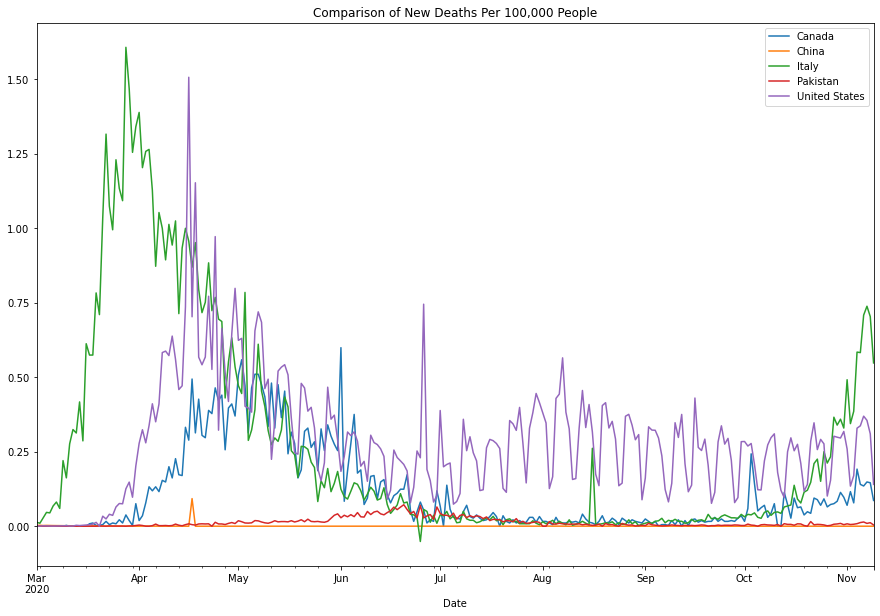

In [63]:
_, ax = plt.subplots(figsize = (15, 10))

ax.set_title('Comparison of New Deaths Per 100,000 People')

for name, group in percapita_deaths.groupby('location'):
    group.plot(kind ='line', y = 'new_deaths_per_capita', ax = ax, label = name)

plt.savefig('select_countries_new_deaths_per_capita.png', bbox_inches = 'tight')

### Highest number of total cases and deaths

In [64]:
highest_total_cases = data.nlargest(5, 'total_cases')
highest_deaths = data.nlargest(5, 'total_deaths')

#### Plots

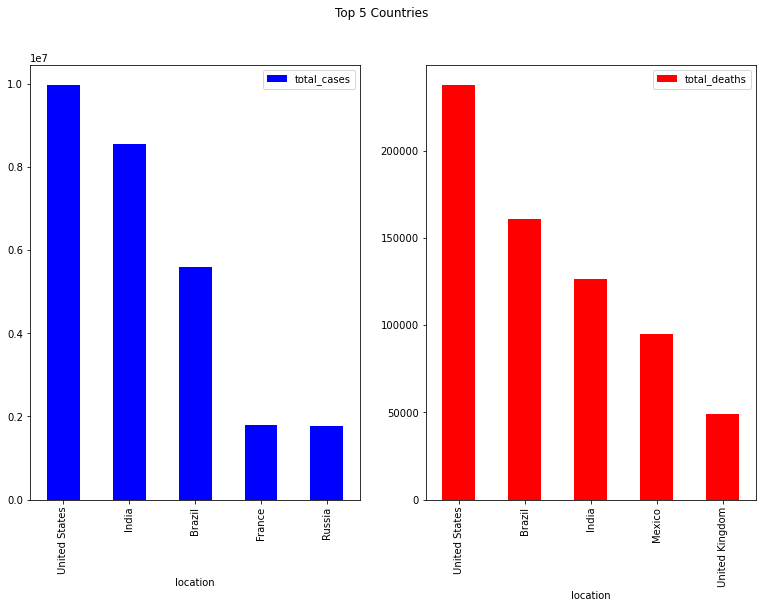

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8))
fig.suptitle('Top 5 Countries')

highest_total_cases.plot(kind = 'bar', y = 'total_cases', color = ['blue'], ax = ax1)
highest_deaths.plot(kind = 'bar', y = 'total_deaths', color = ['red'], ax = ax2)
plt.savefig('highest_total_cases_and_deaths.png', bbox_inches = 'tight')

#### Tables

##### Highest total cases

In [66]:
highest_total_cases

,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,,,,,
United States,110693,459,9971651.0,237572,764289.0,6576.0,1335486.0,12342.0,3047.873952,72.614807,0.0238
India,45903,490,8553657.0,126611,324344.0,4004.0,643698.0,7597.0,632.378192,9.360445,0.0148
Brazil,0,0,5590025.0,161106,44320.0,1032.0,195897.0,3972.0,2668.660333,76.911497,0.0288
France,38619,270,1787324.0,40439,373409.0,3420.0,648817.0,5678.0,2668.155746,60.368210,0.0226
Russia,20498,286,1774334.0,30537,137553.0,2302.0,260457.0,4487.0,1228.099355,21.136083,0.0172


##### Highest total deaths

In [67]:
highest_deaths

,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,,,,,
United States,110693,459,9971651.0,237572,764289.0,6576.0,1335486.0,12342.0,3047.873952,72.614807,0.0238
Brazil,0,0,5590025.0,161106,44320.0,1032.0,195897.0,3972.0,2668.660333,76.911497,0.0288
India,45903,490,8553657.0,126611,324344.0,4004.0,643698.0,7597.0,632.378192,9.360445,0.0148
Mexico,5887,219,967825.0,95027,38433.0,3132.0,76665.0,6103.0,766.953765,75.304229,0.0982
United Kingdom,20572,156,1192013.0,49044,157099.0,2327.0,318213.0,4148.0,1792.797547,73.762587,0.0411


### Canadian provinces and territories

#### Cases and Deaths

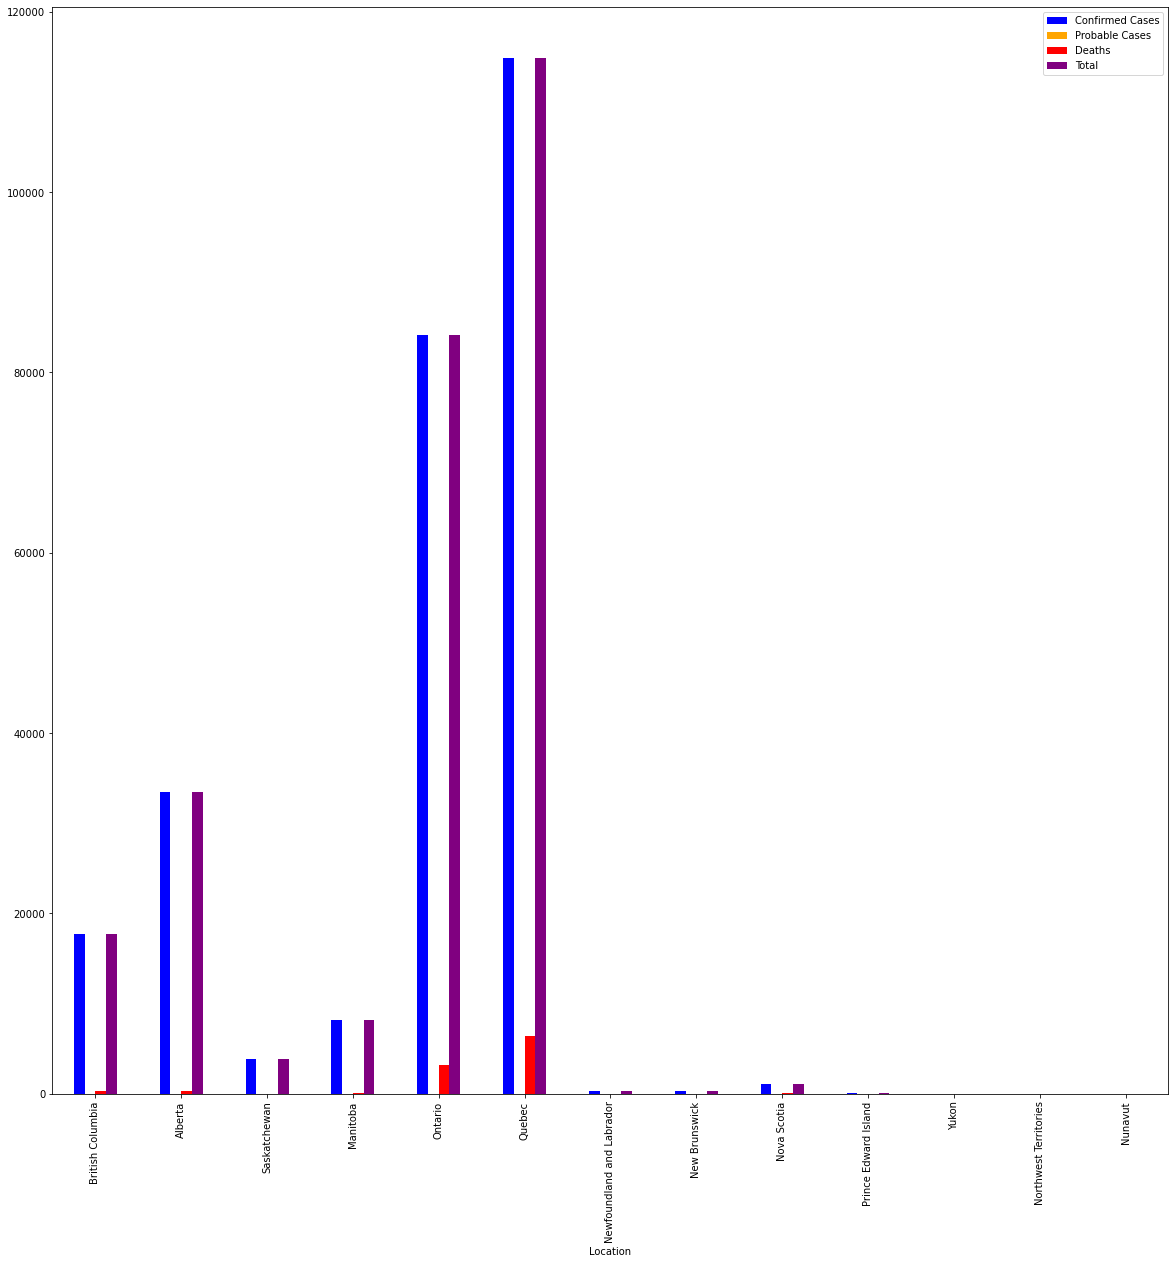

In [68]:
canadian_data.plot(kind = 'bar', y = ['Confirmed Cases', 'Probable Cases', 'Deaths', 'Total'], color = ['blue', 'orange', 'red', 'purple'], figsize = (20,20))
plt.savefig('canadian_provinces_all.png', bbox_inches = 'tight')

In [69]:
canadian_data.sort_values(by = 'Confirmed Cases', ascending = False, inplace = True)

##### Plots

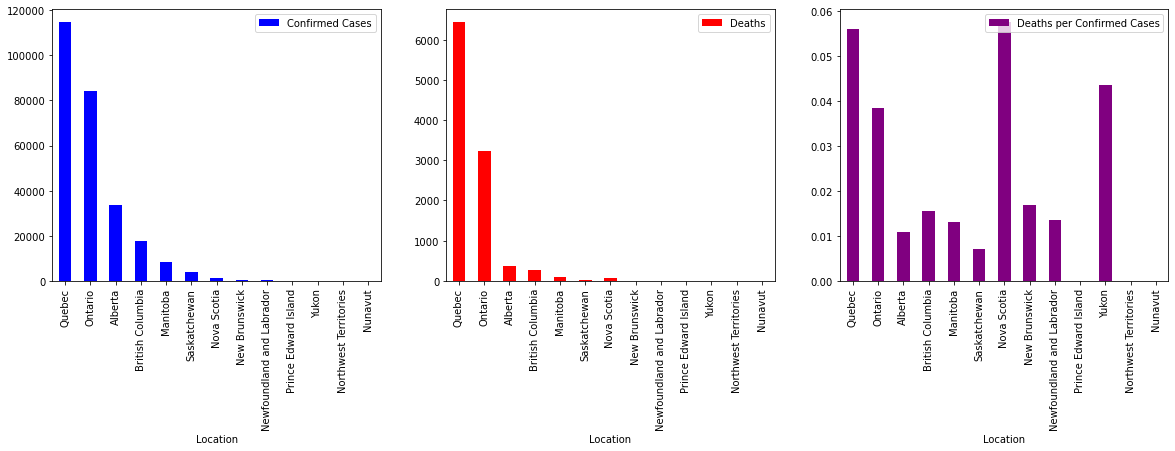

In [70]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
canadian_data.plot(kind = 'bar', y = 'Confirmed Cases', color = ['blue'], ax = ax1)
canadian_data.plot(kind = 'bar', y = 'Deaths', color = ['red'], ax = ax2)
canadian_data.plot(kind = 'bar', y = 'Deaths per Confirmed Cases', color = ['purple'], ax = ax3)
plt.savefig('canadian_provinces.png', bbox_inches = 'tight')

##### Tables

###### Total

In [71]:
canadian_data_total

,Confirmed Cases,Probable Cases,Deaths,Total,numtested,numrecover,percentrecover,ratetested,Today,percentoday,...,numdeaths_last14,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7
Location,,,,,,,,,,,,,,,,,,,,,
Canada,264113,0,10522.0,264113,9935221.0,215005.0,81.41,264310.0,4058,1.56,...,576.0,1.53,25425.0,67.64,343.0,0.91,3632.0,9.66,49.0,0.13


###### Sorted by confirmed cases

In [72]:
canadian_data

,Confirmed Cases,Probable Cases,Deaths,Total,numtested,numrecover,percentrecover,ratetested,Today,percentoday,...,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,Deaths per Confirmed Cases,Confirmed Cases Per Capita,Deaths Per Capita
Location,,,,,,,,,,,,,,,,,,,,,
Quebec,114820,0,6440.0,114820,1965445.0,97789.0,85.17,231639.0,1397,1.23,...,92.39,168.0,1.98,1120.0,13.20,24.0,0.28,0.056088,0.013449,0.000754
Ontario,84153,0,3233.0,84153,5206568.0,71815.0,85.34,357433.0,1328,1.60,...,51.12,88.0,0.60,1064.0,7.30,13.0,0.09,0.038418,0.005720,0.000220
Alberta,33504,0,363.0,33504,1295038.0,24684.0,73.67,296258.0,727,2.22,...,108.30,40.0,0.92,676.0,15.47,6.0,0.13,0.010835,0.007592,0.000082
British Columbia,17716,0,276.0,17716,652024.0,13035.0,73.58,128570.0,0,0.00,...,51.15,13.0,0.26,371.0,7.31,2.0,0.04,0.015579,0.003466,0.000054
Manitoba,8130,0,106.0,8130,270689.0,3175.0,39.05,197660.0,441,5.74,...,153.05,31.0,2.26,299.0,21.86,4.0,0.32,0.013038,0.005902,0.000077
Saskatchewan,3897,0,28.0,3897,221644.0,2747.0,70.49,188720.0,159,4.25,...,57.81,3.0,0.26,97.0,8.26,0.0,0.04,0.007185,0.003298,0.000024
Nova Scotia,1128,0,65.0,1128,118072.0,1043.0,92.46,121549.0,3,0.27,...,1.75,0.0,0.00,2.0,0.25,0.0,0.00,0.057624,0.001154,0.000066
New Brunswick,354,0,6.0,354,87272.0,324.0,91.53,112344.0,1,0.28,...,1.29,0.0,0.00,1.0,0.18,0.0,0.00,0.016949,0.000454,0.000008
Newfoundland and Labrador,297,0,4.0,297,54686.0,286.0,96.30,104854.0,1,0.34,...,1.15,0.0,0.00,1.0,0.16,0.0,0.00,0.013468,0.000570,0.000008


#### Per Capita

##### Plots

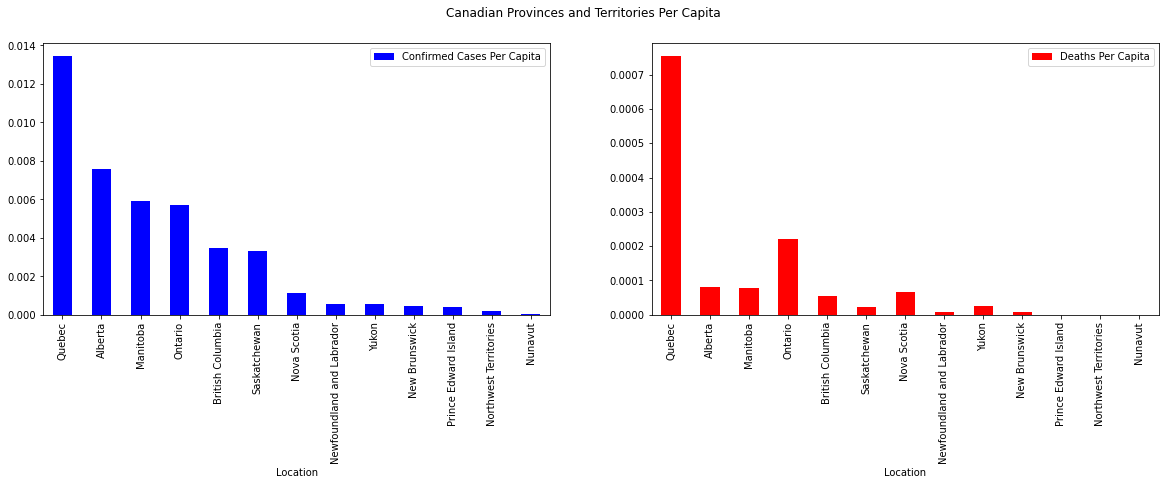

In [73]:
cdata_sorted = canadian_data.sort_values(by = 'Confirmed Cases Per Capita', ascending = False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Canadian Provinces and Territories Per Capita')

cdata_sorted.plot(kind = 'bar', y = 'Confirmed Cases Per Capita', color = ['blue'], ax = ax1)
cdata_sorted.plot(kind = 'bar', y = 'Deaths Per Capita', color = ['red'], ax = ax2)

plt.savefig('canadian_provinces_per_capita.png', bbox_inches = 'tight')

##### Tables

###### Sorted by confirmed cases per capita

In [74]:
cdata_sorted

,Confirmed Cases,Probable Cases,Deaths,Total,numtested,numrecover,percentrecover,ratetested,Today,percentoday,...,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,Deaths per Confirmed Cases,Confirmed Cases Per Capita,Deaths Per Capita
Location,,,,,,,,,,,,,,,,,,,,,
Quebec,114820,0,6440.0,114820,1965445.0,97789.0,85.17,231639.0,1397,1.23,...,92.39,168.0,1.98,1120.0,13.20,24.0,0.28,0.056088,0.013449,0.000754
Alberta,33504,0,363.0,33504,1295038.0,24684.0,73.67,296258.0,727,2.22,...,108.30,40.0,0.92,676.0,15.47,6.0,0.13,0.010835,0.007592,0.000082
Manitoba,8130,0,106.0,8130,270689.0,3175.0,39.05,197660.0,441,5.74,...,153.05,31.0,2.26,299.0,21.86,4.0,0.32,0.013038,0.005902,0.000077
Ontario,84153,0,3233.0,84153,5206568.0,71815.0,85.34,357433.0,1328,1.60,...,51.12,88.0,0.60,1064.0,7.30,13.0,0.09,0.038418,0.005720,0.000220
British Columbia,17716,0,276.0,17716,652024.0,13035.0,73.58,128570.0,0,0.00,...,51.15,13.0,0.26,371.0,7.31,2.0,0.04,0.015579,0.003466,0.000054
Saskatchewan,3897,0,28.0,3897,221644.0,2747.0,70.49,188720.0,159,4.25,...,57.81,3.0,0.26,97.0,8.26,0.0,0.04,0.007185,0.003298,0.000024
Nova Scotia,1128,0,65.0,1128,118072.0,1043.0,92.46,121549.0,3,0.27,...,1.75,0.0,0.00,2.0,0.25,0.0,0.00,0.057624,0.001154,0.000066
Newfoundland and Labrador,297,0,4.0,297,54686.0,286.0,96.30,104854.0,1,0.34,...,1.15,0.0,0.00,1.0,0.16,0.0,0.00,0.013468,0.000570,0.000008
Yukon,23,0,1.0,23,4164.0,20.0,86.96,101924.0,0,0.00,...,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.043478,0.000560,0.000024


###### Population

In [75]:
canadian_population

,Population
Location,
Ontario,14711827
Quebec,8537674
British Columbia,5110917
Alberta,4413146
Manitoba,1377517
Saskatchewan,1181666
Nova Scotia,977457
New Brunswick,779993
Newfoundland and Labrador,521365


# Resources
1. Data obtained from: https://ourworldindata.org/coronavirus-source-data
2. Population data from: https://data.worldbank.org/indicator/SP.POP.TOTL
3. Canadian data: https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html
4. Canadian population: https://en.wikipedia.org/wiki/List_of_Canadian_provinces_and_territories_by_population
5. Deaths from infectious diseases: https://ourworldindata.org/grapher/deaths-from-infections-of-currently-noneradicable-diseases
6. Tuberculosis: https://www.doctorswithoutborders.ca/issues/tuberculosis-deadly-and-neglected